In [1]:
import transformers
import torch
from pathlib import Path
import srsly
import random
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns

transformers.utils.logging.set_verbosity_error()

In [2]:
inputs = list(srsly.read_jsonl("testing-data/cri.jsonl"))

In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct').to('cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B-Instruct', model_max_length=1024)
model.eval();

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
def tokenize(chunk, question, answer):
    prompt = (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
        "\nYou are an excellent student who has just read the following excerpt."
        " The teacher will ask you a question. You will answer accurately."
        f"\n\nExcerpt:\n\n{chunk}<|eot_id|>"
        "\n<|start_header_id|>user<|end_header_id|>"
        f"{question}<|eot_id|>"
        "\n<|start_header_id|>assistant<|end_header_id|>"
    )

    # Inputs
    # Construct inputs separately, so we know where the prompt ends.
    prompt_encoding = tokenizer(prompt, return_tensors="pt", return_length=True, add_special_tokens=False)
    answer_encoding = tokenizer(answer, return_tensors="pt", add_special_tokens=False)
    input_ids = torch.cat((prompt_encoding.input_ids, answer_encoding.input_ids), 1).to('cuda')
    # Targets
    target_ids = input_ids.clone()
    prompt_length = prompt_encoding.length.item()
    # Setting targets to -100 will ignore them when calculating loss
    # Do this for all tokens before the answer.
    target_ids[:, :prompt_length] = -100

    return input_ids, target_ids

In [19]:
def get_loss(input_ids, target_ids):
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # loss is calculated using CrossEntropyLoss which averages over valid labels
    return outputs.loss

outputs = []
for cri_input in tqdm(inputs):
    input_ids, target_ids = tokenize(cri_input["Chunk"], cri_input["Question"], cri_input["answer"])
    # print(tokenizer.decode(input_ids[0]))
    loss = get_loss(input_ids, target_ids)
    cri_input["Loss"] = loss.item()
    outputs.append(cri_input)

  0%|          | 0/2540 [00:00<?, ?it/s]

In [20]:
df = pd.DataFrame(outputs)
df.to_csv("output/cri_loss.csv", index=False)
df.sample(5)

,page_slug,chunk_slug,answer,score,Chunk,Question,Answer,Loss
422,learning-analytics-for-self-regulated-learning,Introduction-496t,P,0,The P slot in the COPES schema represents prod...,What operation generates a special product in ...,E is a monitoring operation that generates a s...,36.383244
1833,learning-an-1,How-to-Get-Started-Chunk-7-538t,compare values and patterns,2,Add Interaction Techniques\n\nVisual analysis ...,What are some common tasks performed by teache...,"Comparing values and patterns, sorting items, ...",9.182517
2345,learning-an-1,Acquire-and-Pre-Process-Your-Data-533t,the step of acquiring the data and pre-process...,2,Building a visual dashboard typically entails ...,What step of building a visual dashboard typic...,Data-gathering and preprocessing step.,5.924104
1679,a-practitioner-s-guide-to-measurement-in-learn...,Challenges-and-Opportunities-451t,idk,0,Measurement of Learning Process\n\nAs illustra...,What are some challenges associated with using...,"Inherent biases, such as individuals interpret...",23.497791
1858,emotional,14-Teacher-Analytics-486t,Researchers are developing methods for automat...,2,Teachers should not be left out of the loop si...,What are researchers developing methods for in...,Researchers are developing methods for automat...,3.983116


## Analysis

In [21]:
df = pd.read_csv("output/cri_loss.csv")
df.sample(2)

,page_slug,chunk_slug,answer,score,Chunk,Question,Answer,Loss
595,learning-analytics-for-self-regulated-learning,Learner-History-501t,It calls for imaginative interfaces that encou...,1,Software Tools for Studying. Data about motiva...,What is the purpose of operationalizing indica...,To develop data that explains why and how lear...,2.454838
184,learning-analytics-for-self-regulated-learning,Data-For-Learning-Analytics-About-Learning-And...,Full coverage where every cognitive operation ...,1,Features of Traces. Four features describe ide...,What are the four features that describe ideal...,The four features are: sampling proportion app...,4.415710


### Correct Answer Loss

In [40]:
gpt_loss_dict = {}
for (chunk, question, answer), group in tqdm(df.groupby(['Chunk', 'Question', 'Answer'])):
    input_ids, target_ids = tokenize(chunk, question, answer)
    loss = get_loss(input_ids, target_ids)
    gpt_loss_dict[question] = loss.item()

df['Gold Loss'] = df['Question'].map(gpt_loss_dict)
df.sample(2)

,page_slug,chunk_slug,answer,score,Chunk,Question,Answer,Loss,Gold Loss
0,learning-analytics-for-self-regulated-learning,LEARNING-ANALYTICS-498t,"multiple actors: authors, instructional design...",2,Who generates data? Who receives learning anal...,Who generates data and receives learning analy...,"Authors, instructional designers, front-line i...",4.053061,3.400246
1,learning-analytics-for-self-regulated-learning,Learner-History-462t,"content highlighted, notes, marginalia, a pile...",2,Instruments for tracing the history of a learn...,What are some examples of traces in a paper-ba...,Examples of traces in a paper-based environmen...,1.847079,0.690509
2,learning-analytics-for-self-regulated-learning,Learner-History-501t,encourage learners to use the tools without di...,1,Software Tools for Studying. Data about motiva...,What is the purpose of operationalizing indica...,To develop data that explains why and how lear...,4.717658,2.524665
3,learning-analytics-for-self-regulated-learning,Learner-History-501t,encourage learners to use software tools witho...,1,Software Tools for Studying. Data about motiva...,What is the purpose of operationalizing indica...,To develop data that explains why and how lear...,3.736045,2.524665
4,learning-analytics-for-self-regulated-learning,LEARNING-ANALYTICS-FOR-SRL-527t,how a learner uses tools in software,2,"The third facet of a learning analytic, the re...",How can recommendations in learning analytics ...,Recommendations in learning analytics can be o...,5.851384,1.199644
...,...,...,...,...,...,...,...,...,...
2535,learning-analytics-for-self-regulated-learning,Learning-Analytics-497t,"Demographic, enrollment, attendance, etc",1,Four descriptions of learning analytics guide ...,What data should be gathered for input to meth...,Data that can be used for computations and ana...,8.488744,5.023488
2536,learning-analytics-for-self-regulated-learning,Learning-Analytics-498t,educators and institutions,1,Who generates data? Who receives learning anal...,Who generates data and receives learning analy...,"Authors, instructional designers, front-line i...",12.032743,3.400246
2537,learning-analytics-for-self-regulated-learning,Learning-Analytics-498t,educators and institutions,1,Who generates data? Who receives learning anal...,Who generates data and receives learning analy...,"Authors, instructional designers, front-line i...",12.032743,3.400246
2538,learning-analytics-for-self-regulated-learning,Data-For-Learning-Analytics-About-Learning-And...,"granularity, timeliness, contextualization, ac...",0,Features of Traces. Four features describe ide...,What are the four features that describe ideal...,The four features are: sampling proportion app...,5.347507,1.973422


In [41]:
df.describe()

,score,Loss,Gold Loss
count,2540.000000,2540.000000,2540.000000
mean,1.556693,7.571470,2.712413
std,0.696821,7.589023,0.981478
min,0.000000,0.814764,0.690509
25%,1.000000,3.602604,2.059074
50%,2.000000,5.147290,2.715271
75%,2.000000,7.898194,3.260715
max,2.000000,46.967705,5.209279


### Distributions

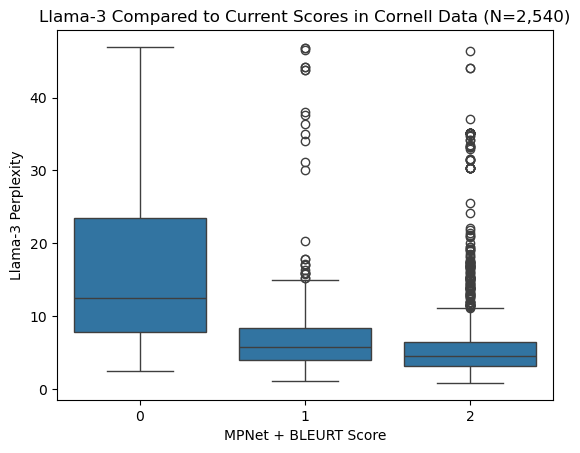

In [22]:
ax = sns.boxplot(data=df, x="score", y="Loss")
ax.set_title("Llama-3 Compared to Current Scores in Cornell Data (N=2,540)")
ax.set_xlabel("MPNet + BLEURT Score")
ax.set_ylabel("Llama-3 Perplexity");

In [23]:
max_loss = 10
min_score = 1
print(f'Loss greater than {max_loss}: {df[df["Loss"] > max_loss ].shape[0]}')
print(f'Score less than {min_score}: {df[df["score"] < min_score ].shape[0]}')

Loss greater than 10: 453
Score less than 1: 303


### Disagreements

In [29]:
# filtered_df = df[(df['Loss'] > 10) & (df['score'] > 0 )]
filtered_df = df[(df['Loss'] < 10) & (df['score'] == 0)]

# gold_answers = df.loc[df.groupby('Question')['Loss'].idxmin()][['Question', 'answer']]
# gold_answers.rename(columns={'answer': 'Gold'}, inplace=True)
# filtered_df = pd.merge(filtered_df, gold_answers, on='Question', how='left')
filtered_df = filtered_df[["Question", "answer", "Answer", "score", "Loss"]].rename(columns={
    "answer": "Student Answer",
    "Answer": "GPT-4 Answer",
    "score": "Current Score",
    "Loss": "Llama Loss",
})
print("Rows Remaining: ", filtered_df.shape[0])

Rows Remaining:  113


In [30]:
filtered_df.style.set_properties(
    **{
        'overflow-wrap': 'break-word',
    }
).set_properties(
    **{
        'width': '400px'
    },
    subset=["Question", "GPT-4 Answer"]
).map(
    lambda x: 'font-weight: bold; color: blue;', subset=['Question']
).map(
    lambda x: 'color: red;', subset=['Student Answer', "Current Score", "Llama Loss"]
).map(
    lambda x: 'color: green;', subset=['GPT-4 Answer']
)

,Question,Student Answer,GPT-4 Answer,Current Score,Llama Loss
39,What data should be gathered for input to methods used to generate learning analytics?,ordinal (rank),Data that can be used for computations and analysis to predict student progress and performance.,0,9.300089
62,What is the purpose of operationalizing indicators to trace COPES in software tools for studying?,So students use the software without changing their work habits,"To develop data that explains why and how learners develop knowledge, beliefs, attitudes, and interests.",0,8.144103
63,What are researchers developing methods for in order to quantify teacher instructional practices?,live observations in classrooms,Researchers are developing methods for automatic analysis of teacher instructional practices.,0,8.282579
93,Can computers with predictive modeling capabilities truly 'understand' concepts like the difference between a dog and a fire hydrant?,"No, computers with these capacibilities still cannot truly understand the difference between a dog and a fire hydrant","No, computers with predictive modeling capabilities do not truly 'understand' concepts like the difference between a dog and a fire hydrant.",0,4.013904
171,How do self-regulating learners adapt their skills when faced with sub-standard characteristics of operations and products?,IF-THEN-ELSE model,Self-regulating learners strive to adapt skills or remove/reconfigure conditions that bear on applying skills.,0,6.459539
204,What is the purpose of operationalizing indicators to trace COPES in software tools for studying?,calls for imaginative interfaces,"To develop data that explains why and how learners develop knowledge, beliefs, attitudes, and interests.",0,9.123840
273,"What was a significant finding in the study by San Pedro, Baker, Bowers, & Heffernan regarding college enrollment prediction?",The models were generalizable to different groups.,Automatically measured affective states were significant predictors of college enrollment several years later.,0,9.325598
284,What types of data can be incorporated into a dashboard according to Verbert et al. (2014)?,physical and emotional states of learners,"Artefacts produced by learners, social interaction, resource use, time spent, and test/self-assessment results.",0,7.324848
293,What questions need to be answered during the initial step of the design process?,"why, for whom","Questions about the goal of the visualization, intended users, data to be displayed, and how the visualization will support the goal.",0,8.934854
313,How should learning analytics be adapted to help learners develop multiplex learning skills?,They should be adapted based on the goals of the SRLer.,Learning analytics should be delivered just-in-time to support progressive self-regulated learning.,0,6.173824


In [26]:
df.describe()

,score,Loss
count,2540.000000,2540.000000
mean,1.556693,7.571470
std,0.696821,7.589023
min,0.000000,0.814764
25%,1.000000,3.602604
50%,2.000000,5.147290
75%,2.000000,7.898194
max,2.000000,46.967705


In [27]:
df.score.corr(df.Loss, method='spearman') 

-0.3904406219163872

In [28]:
df.answer.str.split().str.len().corr(df.Loss)

-0.4709376890682331